In [26]:
!pip install -q flwr

In [27]:
!pip install -U flwr

In [28]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation


# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002)(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
rmse.__name__ = "rmse"

def compile_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
                  loss=rmse,
                  metrics=['accuracy', 'mae', rmse])
    return model

# --- Split data across clients ---
def split_data(num_clients):
    X_audio_all = X_audio_train
    X_text_all = X_text_train
    y_all = y_train
    size = len(y_all) // num_clients
    return [
        (X_audio_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_all[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)
global_metrics = {"accuracy": [], "mae": [], "rmse": [], "f1_score": [], "precision": [], "recall": []}

# --- Custom Strategy (using dev set for per-round eval) ---
class ScaffoldStrategy(FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def aggregate_fit(self, rnd, results, failures):
        aggregated_parameters, metrics_aggregated = super().aggregate_fit(rnd, results, failures)
        return aggregated_parameters, metrics_aggregated

# --- Client Definition ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio, X_text, y):
        self.model = model
        self.X_audio_train, self.X_audio_test, self.X_text_train, self.X_text_test, self.y_train, self.y_test = train_test_split(
            X_audio, X_text, y, test_size=0.1, random_state=42)

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit([self.X_audio_train, self.X_text_train], self.y_train,
                       batch_size=32, epochs=2, verbose=0, shuffle=True)
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate([self.X_audio_test, self.X_text_test], self.y_test, verbose=0)
        return float(loss), len(self.y_test), {
            "accuracy": float(acc), "mae": float(mae), "rmse": float(rmse_val)}

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App (evaluation on dev set) ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        model.set_weights(parameters)
        y_pred = model.predict([X_audio_dev, X_text_dev])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_dev, y_pred_labels)
        f1 = f1_score(y_dev, y_pred_labels)
        prec = precision_score(y_dev, y_pred_labels)
        rec = recall_score(y_dev, y_pred_labels)
        mae_val = np.mean(np.abs(y_dev - y_pred))
        rmse_val = np.sqrt(np.mean((y_dev - y_pred) ** 2))

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)

        print(f"\n📊 Round {server_round} — Dev: Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
        }

    strategy = ScaffoldStrategy(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Config ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=34717) 2025-07-06 15:14:54.283919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=34724) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=34724) E0000 00:00:1751814894.305116   34724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=34717) E0000 00:00:1751814894.384925   34717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=34716) 2025-07-06 15:15:05.010303: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step

📊 Round 0 — Dev: Acc=0.5108, F1=0.5992, Prec=0.5075, Rec=0.7313, MAE=0.5002, RMSE=0.5004


INFO :      initial parameters (loss, other metrics): 0.5004458427429199, {'accuracy': 0.5107758620689655, 'f1_score': 0.5991759858740435, 'precision': 0.5074775672981057, 'recall': 0.7313218390804598, 'mae': 0.5002292394638062, 'rmse': 0.5004458427429199}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=34714) 2025-07-06 15:15:21.534164: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=34717) 2025-07-06 15:15:21.566386: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step

📊 Round 1 — Dev: Acc=0.4842, F1=0.4338, Prec=0.4808, Rec=0.3951, MAE=0.5002, RMSE=0.5006


INFO :      fit progress: (1, 0.5005536675453186, {'accuracy': 0.48419540229885055, 'f1_score': 0.43375394321766564, 'precision': 0.4807692307692308, 'recall': 0.39511494252873564, 'mae': 0.5002143383026123, 'rmse': 0.5005536675453186}, 389.37277788999927)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step

📊 Round 2 — Dev: Acc=0.4864, F1=0.4294, Prec=0.4829, Rec=0.3865, MAE=0.5002, RMSE=0.5007


INFO :      fit progress: (2, 0.5007451772689819, {'accuracy': 0.4863505747126437, 'f1_score': 0.4293695131683959, 'precision': 0.4829443447037702, 'recall': 0.3864942528735632, 'mae': 0.5002105832099915, 'rmse': 0.5007451772689819}, 836.561349956999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 2596 MiB, 3 objects, write throughput 244 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=34724) 2025-07-06 15:15:21.562409: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step

📊 Round 3 — Dev: Acc=0.4943, F1=0.4395, Prec=0.4929, Rec=0.3966, MAE=0.5002, RMSE=0.5011


INFO :      fit progress: (3, 0.5010519623756409, {'accuracy': 0.4942528735632184, 'f1_score': 0.4394904458598726, 'precision': 0.4928571428571429, 'recall': 0.39655172413793105, 'mae': 0.5002056956291199, 'rmse': 0.5010519623756409}, 1257.643711118999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 5193 MiB, 6 objects, write throughput 271 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step

📊 Round 4 — Dev: Acc=0.4993, F1=0.4411, Prec=0.4991, Rec=0.3951, MAE=0.5001, RMSE=0.5014


INFO :      fit progress: (4, 0.5014360547065735, {'accuracy': 0.4992816091954023, 'f1_score': 0.44105854049719323, 'precision': 0.49909255898366606, 'recall': 0.39511494252873564, 'mae': 0.5001216530799866, 'rmse': 0.5014360547065735}, 1706.3164225499968)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step

📊 Round 5 — Dev: Acc=0.4964, F1=0.4351, Prec=0.4954, Rec=0.3879, MAE=0.4999, RMSE=0.5019


INFO :      fit progress: (5, 0.5019352436065674, {'accuracy': 0.4964080459770115, 'f1_score': 0.43513295729250606, 'precision': 0.4954128440366973, 'recall': 0.3879310344827586, 'mae': 0.499929279088974, 'rmse': 0.5019352436065674}, 2115.5236295549985)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2131.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5023754358291626
INFO :      		round 2: 0.504012155532837
INFO :      		round 3: 0.5016091525554657
INFO :      		round 4: 0.5021188855171204
INFO :      		round 5: 0.49950202107429503
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5004458427429199
INFO :      		round 1: 0.5005536675453186
INFO :      		round 2: 0.5007451772689819
INFO :      		round 3: 0.5010519623756409
INFO :      		round 4: 0.5014360547065735
INFO :      		round 5:

In [29]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

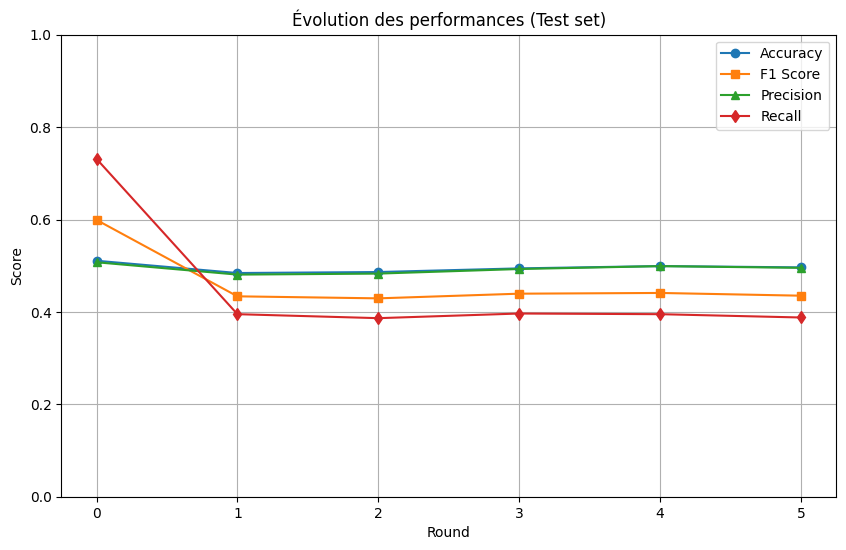

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


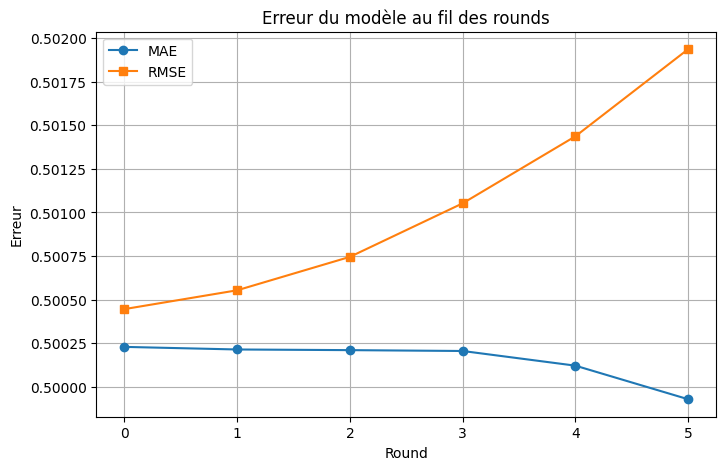

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


🎯 Final Evaluation on Test Set:
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step

✅ Test Accuracy: 0.4749
✅ F1 Score: 0.6171
✅ Precision: 0.4856
✅ Recall: 0.8463
✅ MAE: 0.4995
✅ RMSE: 0.5003

🧩 Confusion Matrix:
[[ 72 624]
 [107 589]]


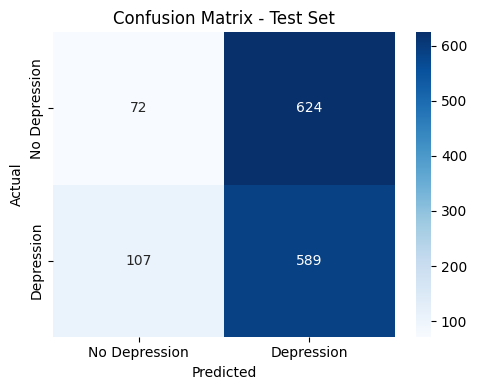

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Final Evaluation on TEST SET ---
final_model = compile_model()
# ⚠️ Replace with last global weights if saved; this is placeholder:
# final_model.set_weights(last_global_weights)

print("\n🎯 Final Evaluation on Test Set:")
y_pred_test = final_model.predict([X_audio_test, X_text_test])
y_pred_labels_test = (y_pred_test > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred_labels_test)
f1 = f1_score(y_test, y_pred_labels_test)
prec = precision_score(y_test, y_pred_labels_test)
rec = recall_score(y_test, y_pred_labels_test)
mae_val = np.mean(np.abs(y_test - y_pred_test))
rmse_val = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
cm = confusion_matrix(y_test, y_pred_labels_test)

# Display results
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ MAE: {mae_val:.4f}")
print(f"✅ RMSE: {rmse_val:.4f}")
print("\n🧩 Confusion Matrix:")
print(cm)

# Optional: plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Depression", "Depression"], yticklabels=["No Depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
